In [1]:
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 1.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 6.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 51.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━

In [2]:
!pip install triton==3.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 MB 6.6 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: triton
    Found existing installation: triton 3.3.0
    Uninstalling triton-3.3.0:
      Successfully uninstalled triton-3.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.7.0 requires triton==3.3.0; platform_system == "Linux" and platform_machine == "x86_64", but you have triton 3.2.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.


In [3]:
from unsloth import FastVisionModel, is_bfloat16_supported
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig


from transformers import TrainingArguments, EarlyStoppingCallback

from unsloth.trainer import UnslothVisionDataCollator
import torch
from datasets import load_dataset, DatasetDict, load_from_disk

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-06-26 16:51:20.396250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750956680.815620      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750956680.929407      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!


In [6]:
# base_data_folder = "/content/drive/MyDrive/Datasets/Datasets/Malayalam_HRT/Qwen_data/8K8h8h"
train_folder = "/kaggle/input/train-data"
val_foder = "/kaggle/input/val-data"
test_folder = "/kaggle/input/test-data"

In [7]:

train_dataset = load_from_disk(train_folder)
val_dataset = load_from_disk(val_foder)
test_dataset = load_from_disk(test_folder)

In [8]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 8000
Validation size: 800
Test size: 800


In [8]:
instruction = "Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["text"]} ]
        },
    ]
    return { "messages" : conversation }
pass

In [9]:
converted_train_dataset = [convert_to_conversation(sample) for sample in train_dataset]
converted_val_dataset = [convert_to_conversation(sample) for sample in val_dataset]
converted_test_dataset = [convert_to_conversation(sample) for sample in test_dataset]

In [25]:
converted_train_dataset[7]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=480x76>}]},
  {'role': 'assistant',
   'content': [{'type': 'text', 'text': 'അപ്പുറത്തുള്ള'}]}]}

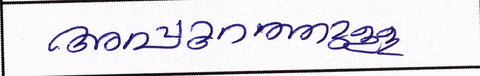

In [24]:
converted_train_dataset[7]['messages'][0]['content'][1]['image']

In [31]:
MODEL_NAME = "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit"

In [32]:
model, tokenizer = FastVisionModel.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    device_map="auto",
    # torch_dtype=torch.float16,
    use_gradient_checkpointing=True,  # Critical for T4 memory
    attn_implementation="sdpa",  # Flash attention might be too heavy for T4
)

==((====))==  Unsloth 2025.6.6: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.97G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [44]:

model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,
    r=32,  # Reduced from 32 to fit T4
    lora_alpha=32,
    lora_dropout=0.1,  # Reduced dropout
    bias="lora_only",  # No bias to save memory
    use_rslora=True,  # Disabled for T4
    target_modules=["q_proj","k_proj", "v_proj","o_proj"],  # Only target key projections
)

Unsloth: Making `model.base_model.model.model` require gradients


In [47]:
torch.cuda.device_count()

2

In [48]:
training_args = SFTConfig(
    per_device_train_batch_size=4,  # Must be 2 on T4
    gradient_accumulation_steps=2,  # Increased to compensate
    warmup_ratio=0.1,  # Shorter warmup
    num_train_epochs=3,  # Reduced epochs
    learning_rate=2e-4,  # Slightly lower LR
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,  # Less frequent evaluation
    save_strategy="steps",
    save_steps=200,
    save_total_limit=3,  # Only keep 1 checkpoint
    optim="adamw_8bit",
    weight_decay=0.01,  # Reduced
    lr_scheduler_type="cosine",  # Simpler than cosine
    seed=3407,
    output_dir="outputs",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    remove_unused_columns=False,
    max_seq_length=2048,  # Reduced from 2048
    fp16=True,
    gradient_checkpointing=True
    # dataloader_num_workers=2
)

In [49]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.01
)

In [50]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=converted_train_dataset,
    eval_dataset=converted_val_dataset,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    callbacks=[early_stopping]
)

Unsloth: Model does not have a default image size - using 512


In [51]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 2
   \\   /|    Num examples = 8,000 | Num Epochs = 3 | Total steps = 3,000
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 20,185,088/7,000,000,000 (0.29% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
100,0.316100,0.288481
200,0.261900,0.247229
300,0.213400,0.215941
400,0.175900,0.186129
500,0.150400,0.158375
600,0.151500,0.155099
700,0.137000,0.154086
800,0.146800,0.136419
900,0.128700,0.132585
1000,0.119600,0.128664


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [73]:
trainer.save_model("t4_finetuned_model")
tokenizer.save_pretrained("t4_finetuned_model")

[]

**Testing Model**

**Zero Shot pred**

In [10]:
MODEL_NAME = "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit"

model, tokenizer = FastVisionModel.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    device_map="auto",
    # torch_dtype=torch.float16,
    use_gradient_checkpointing=True,  # Critical for T4 memory
    attn_implementation="sdpa",  # Flash attention might be too heavy for T4
)

==((====))==  Unsloth 2025.6.6: Fast Qwen2_5_Vl patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.97G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

In [13]:
import random

# Set random seed for reproducibility
random.seed(42)
# Select 10 random samples
sample_test_data= test_dataset.select(range(10))

In [14]:
sample_test_data

Dataset({
    features: ['image', 'text'],
    num_rows: 10
})

নিবাসে<|im_end|>

Sample 0:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
নিবাসে
Ground Truth Text: വിശ്വാസങ്ങളുടെയും


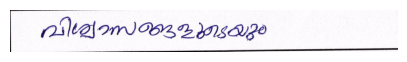

தமிழகஹளியர<|im_end|>

Sample 1:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
தமிழகஹளியர
Ground Truth Text: കൈക്കൂലിയും


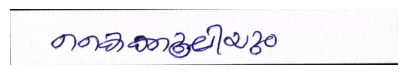

พีระมิตร<|im_end|>

Sample 2:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
พีระมิตร
Ground Truth Text: വീണ്ടുവിചാരമാണ്


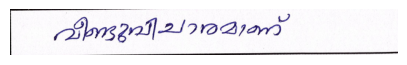

పురాతనం<|im_end|>

Sample 3:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
పురాతనం
Ground Truth Text: കോടതിക്ക്


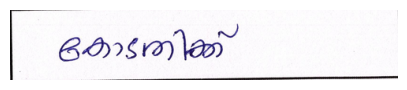

เกณฑ์คุณภาพ<|im_end|>

Sample 4:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
เกณฑ์คุณภาพ
Ground Truth Text: പോകുന്നില്ല


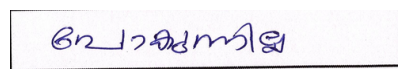

อาต่อในปรสิต<|im_end|>

Sample 5:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
อาต่อในปรสิต
Ground Truth Text: താത്പര്യമോ


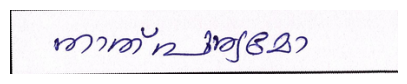

mugerso<|im_end|>

Sample 6:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
mugerso
Ground Truth Text: സുലഭം


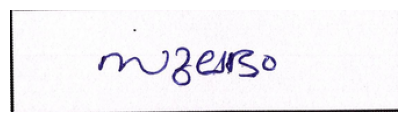

 næromæmæzi<|im_end|>

Sample 7:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
 næromæmæzi
Ground Truth Text: അനുസരിച്ച്


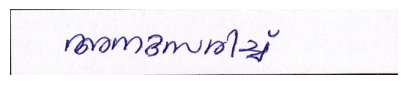

కనేపోపాయబజగొఅదగ<|im_end|>

Sample 8:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
కనేపోపాయబజగొఅదగ
Ground Truth Text: തിരികൊളുത്തിയിരിക്കുകയാണ്


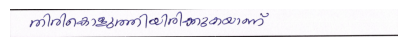

కార్స్ల్<|im_end|>

Sample 9:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
కార్స్ల్
Ground Truth Text: കിട്ടാതെ


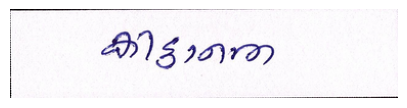

In [16]:
 import matplotlib.pyplot as plt

# model2, tokenizer2 = FastVisionModel.from_pretrained(
#     model_name = "/kaggle/working/t4_finetuned_model", # YOUR MODEL YOU USED FOR TRAINING
#     load_in_4bit = True, # Set to False for 16bit LoRA
# )
# FastVisionModel.for_inference(model) # Enable for inference!

instruction = "Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations."

# Loop through test_dataset
for i, data in enumerate(sample_test_data):
    image = data['image']
    ground_truth = data['text']
    
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    generated_output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                                     use_cache = True, temperature = 1.5, min_p = 0.1)

    # Decode the generated output to get the predicted text
    predicted_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)

    # Print index, predicted, and ground truth text
    print(f"\nSample {i}:")
    print("Predicted Text:", predicted_text)
    print("Ground Truth Text:", ground_truth)

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

**Loading finetuned adapter**

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

In [19]:
base_model_name = model
adapter_path = "/kaggle/working/t4_finetuned_model"  

In [25]:
model_new = model

In [27]:
= tokenizer

In [32]:
peftm_model = PeftModel.from_pretrained(base_model_name, adapter_path)
model_merge = peftm_model .merge_and_unload() 

വിലചനങ്ങളുപരമയും<|im_end|>

Sample 0:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
വിലചനങ്ങളുപരമയും
Ground Truth Text: വിശ്വാസങ്ങളുടെയും


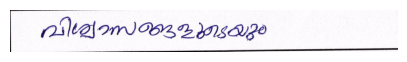

റരക്കെട്ടിയും<|im_end|>

Sample 1:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
റരക്കെട്ടിയും
Ground Truth Text: കൈക്കൂലിയും


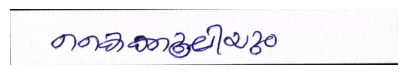

വിഷുപിചരമമാന്<|im_end|>

Sample 2:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
വിഷുപിചരമമാന്
Ground Truth Text: വീണ്ടുവിചാരമാണ്


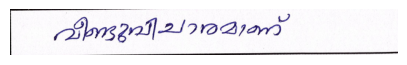

കോടതിക്ക്<|im_end|>

Sample 3:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
കോടതിക്ക്
Ground Truth Text: കോടതിക്ക്


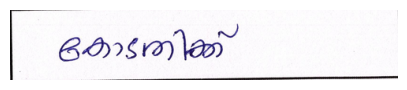

പോട്ടലതിയ {{--<<|im_end|>

Sample 4:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
പോട്ടലതിയ {{--<
Ground Truth Text: പോകുന്നില്ല


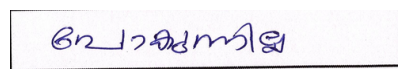

താരപ്പുട്ടമ്മമിച്ചിക്കെട്ട<|im_end|>

Sample 5:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
താരപ്പുട്ടമ്മമിച്ചിക്കെട്ട
Ground Truth Text: താത്പര്യമോ


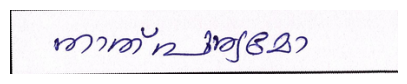

സുല്പം<|im_end|>

Sample 6:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
സുല്പം
Ground Truth Text: സുലഭം


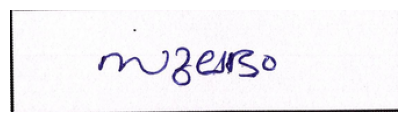

തരനെസയിച്ച്<|im_end|>

Sample 7:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
തരനെസയിച്ച്
Ground Truth Text: അനുസരിച്ച്


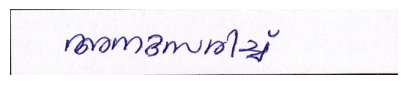

തിരികളുമെപ്പിയിനെക്കുറവ്<|im_end|>

Sample 8:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
തിരികളുമെപ്പിയിനെക്കുറവ്
Ground Truth Text: തിരികൊളുത്തിയിരിക്കുകയാണ്


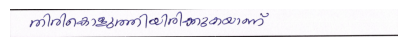

കിടാതെ<|im_end|>

Sample 9:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
കിടാതെ
Ground Truth Text: കിട്ടാതെ


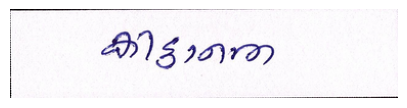

In [35]:
import matplotlib.pyplot as plt

# model2, tokenizer2 = FastVisionModel.from_pretrained(
#     model_name = "/kaggle/working/t4_finetuned_model", # YOUR MODEL YOU USED FOR TRAINING
#     load_in_4bit = True, # Set to False for 16bit LoRA
# )
# FastVisionModel.for_inference(model) # Enable for inference!

instruction = "Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations."

# Loop through test_dataset
for i, data in enumerate(sample_test_data):
    image = data['image']
    ground_truth = data['text']
    
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer_new.apply_chat_template(messages, add_generation_prompt = True)
    inputs = tokenizer_new(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    generated_output = model_merge.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                                     use_cache = True, temperature = 1.5, min_p = 0.1)

    # Decode the generated output to get the predicted text
    predicted_text = tokenizer_new.decode(generated_output[0], skip_special_tokens=True)

    # Print index, predicted, and ground truth text
    print(f"\nSample {i}:")
    print("Predicted Text:", predicted_text)
    print("Ground Truth Text:", ground_truth)

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

In [ ]:
# subset = test_dataset.select(range(n))  # Takes first n samples
# subset = test_dataset.select(range(start_idx, end_idx + 1))

In [36]:
# Set random seed for reproducibility
random.seed(10)
# Select 10 random samples
sample_test_data2= test_dataset.select(range(15))


വിലചനങ്ങളുമകമയയയരും<|im_end|>

Sample 0:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
വിലചനങ്ങളുമകമയയയരും
Ground Truth Text: വിശ്വാസങ്ങളുടെയും


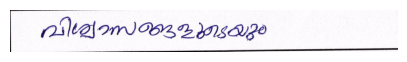

രരുതട്ടെട്ടിയും<|im_end|>

Sample 1:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
രരുതട്ടെട്ടിയും
Ground Truth Text: കൈക്കൂലിയും


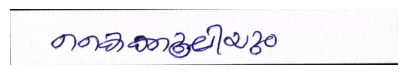

സീഷ്ടമിചരവയംതാണ്<|im_end|>

Sample 2:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
സീഷ്ടമിചരവയംതാണ്
Ground Truth Text: വീണ്ടുവിചാരമാണ്


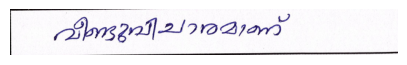

കോടതിക്ക്<|im_end|>

Sample 3:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
കോടതിക്ക്
Ground Truth Text: കോടതിക്ക്


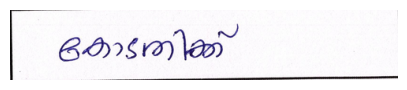

പോരട്ടനടിസ്ഥിയ<|im_end|>

Sample 4:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
പോരട്ടനടിസ്ഥിയ
Ground Truth Text: പോകുന്നില്ല


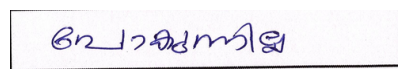

താരപ്പര്യുമമരാവഹം<|im_end|>

Sample 5:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
താരപ്പര്യുമമരാവഹം
Ground Truth Text: താത്പര്യമോ


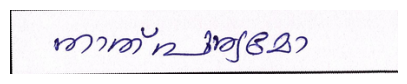

സുലയം<|im_end|>

Sample 6:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
സുലയം
Ground Truth Text: സുലഭം


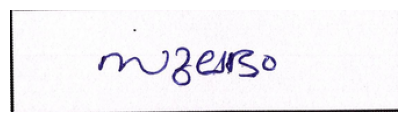

തരനടകസവിച്ച്<|im_end|>

Sample 7:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
തരനടകസവിച്ച്
Ground Truth Text: അനുസരിച്ച്


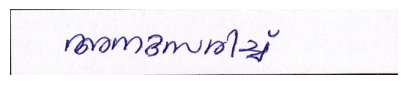

തിരികളുമ്ഞിയിനങ്ങളയാണ്<|im_end|>

Sample 8:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
തിരികളുമ്ഞിയിനങ്ങളയാണ്
Ground Truth Text: തിരികൊളുത്തിയിരിക്കുകയാണ്


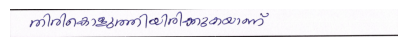

കിട്ടരെ<|im_end|>

Sample 9:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
കിട്ടരെ
Ground Truth Text: കിട്ടാതെ


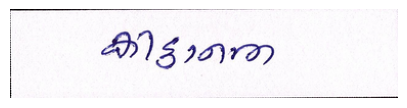

വനറിടീരങ്ങളതന്നസ്<|im_end|>

Sample 10:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
വനറിടീരങ്ങളതന്നസ്
Ground Truth Text: വന്നിരിക്കുകയാണെന്ന്


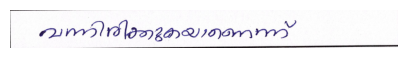

പറിഗണികതായി<|im_end|>

Sample 11:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
പറിഗണികതായി
Ground Truth Text: പരിഗണിക്കാനായി


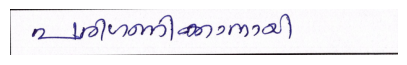

ഈാതിയിഷ്യവതരമ്<|im_end|>

Sample 12:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
ഈാതിയിഷ്യവതരമ്
Ground Truth Text: ഇല്ലാതായിപ്പോയത്


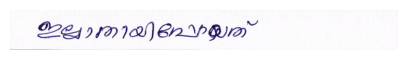

ഏദേദരയെം<|im_end|>

Sample 13:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
ഏദേദരയെം
Ground Truth Text: ഏകദേശം


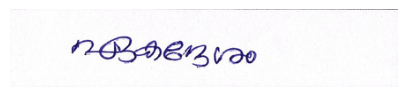

വ്യപങ്ങളും<|im_end|>

Sample 14:
Predicted Text: system
You are a helpful assistant.
user
Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations.
assistant
വ്യപങ്ങളും
Ground Truth Text: ഭപന്തളം


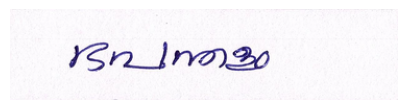

In [37]:
import  matplotlib.pyplot as plt

# model2, tokenizer2 = FastVisionModel.from_pretrained(
#     model_name = "/kaggle/working/t4_finetuned_model", # YOUR MODEL YOU USED FOR TRAINING
#     load_in_4bit = True, # Set to False for 16bit LoRA
# )
# FastVisionModel.for_inference(model) # Enable for inference!

instruction = "Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations."

# Loop through test_dataset
for i, data in enumerate(sample_test_data2):
    image = data['image']
    ground_truth = data['text']
    
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer_new.apply_chat_template(messages, add_generation_prompt = True)
    inputs = tokenizer_new(
        image,
        input_text,
        add_special_tokens = False,
        return_tensors = "pt",
    ).to("cuda")

    from transformers import TextStreamer
    text_streamer = TextStreamer(tokenizer, skip_prompt = True)
    generated_output = model_merge.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                                     use_cache = True, temperature = 1.5, min_p = 0.1)

    # Decode the generated output to get the predicted text
    predicted_text = tokenizer_new.decode(generated_output[0], skip_special_tokens=True)

    # Print index, predicted, and ground truth text
    print(f"\nSample {i}:")
    print("Predicted Text:", predicted_text)
    print("Ground Truth Text:", ground_truth)

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

In [39]:
type(test_dataset)

datasets.arrow_dataset.Dataset

In [88]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "/kaggle/working/t4_finetuned_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = test_dataset[100]['image']
instruction = "Convert the text in the image to digital text. Requirements:- Output Only text: Return only the text content without extra explanations."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

എവിടെയാകുമത്താണ്<|im_end|>


In [93]:
import logging


In [113]:
import torch
torch.cuda.empty_cache()

In [115]:
print(torch.cuda.get_device_properties(0).total_memory / 1024**3, "GB")  # Total GPU memory
print(torch.cuda.memory_allocated(0) / 1024**3, "GB")  # Currently used

14.74127197265625 GB
13.368646144866943 GB


In [61]:
!pip install -U -q PyDrive


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [133]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [134]:
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [45]:
# !cp /kaggle/working/my_file.txt /kaggle/working/outputs

In [135]:
source_dir = '/kaggle/working/t4_finetuned_model'

In [136]:
destination_folder_id = '1BbufXp-ON3sCFlc2qY-OkZPEJ8TZ5YNq'

In [137]:
destination_folder_name_on_drive = 'fine-tuned'

In [138]:
def create_drive_folder(name, parent_id=None):
    file_list = drive.ListFile({'q': f"'{parent_id}' in parents and title='{name}' and trashed=false"}).GetList()
    if file_list:
        return file_list[0]['id']
    else:
        folder_metadata = {'title': name, 'mimeType': 'application/vnd.google-apps.folder'}
        if parent_id:
            folder_metadata['parents'] = [{'id': parent_id}]
        folder = drive.CreateFile(folder_metadata)
        folder.Upload()
        print(f"Created folder '{name}' with ID: {folder['id']}")
        return folder['id']

In [139]:
def upload_folder_to_drive(local_path, drive_parent_id):
    if os.path.isfile(local_path):
        # It's a file, upload it directly
        file_name = os.path.basename(local_path)
        print(f"Uploading file: {file_name} to folder ID: {drive_parent_id}")
        file_metadata = {'title': file_name, 'parents': [{'id': drive_parent_id}]}
        f = drive.CreateFile(file_metadata)
        f.SetContentFile(local_path)
        f.Upload()
        print(f"Uploaded: {file_name}")
    elif os.path.isdir(local_path):
        # It's a directory, create it on Drive and recurse
        dir_name = os.path.basename(local_path)
        new_drive_folder_id = create_drive_folder(dir_name, drive_parent_id)
        for item_name in os.listdir(local_path):
            item_path = os.path.join(local_path, item_name)
            upload_folder_to_drive(item_path, new_drive_folder_id)

In [140]:
final_destination_folder_id = create_drive_folder(destination_folder_name_on_drive, destination_folder_id)


In [141]:
print(f"Starting upload of '{source_dir}' to Google Drive folder '{destination_folder_name_on_drive}' (ID: {final_destination_folder_id})")

# Iterate through the contents of the source_dir and upload
for item in os.listdir(source_dir):
    item_path = os.path.join(source_dir, item)
    upload_folder_to_drive(item_path, final_destination_folder_id)

print(f"Finished transferring '{source_dir}' to Google Drive.")

Starting upload of '/kaggle/working/t4_finetuned_model' to Google Drive folder 'fine-tuned' (ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc)
Uploading file: chat_template.json to folder ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc
Uploaded: chat_template.json
Uploading file: training_args.bin to folder ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc
Uploaded: training_args.bin
Uploading file: special_tokens_map.json to folder ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc
Uploaded: special_tokens_map.json
Uploading file: tokenizer.json to folder ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc
Uploaded: tokenizer.json
Uploading file: preprocessor_config.json to folder ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc
Uploaded: preprocessor_config.json
Uploading file: tokenizer_config.json to folder ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc
Uploaded: tokenizer_config.json
Uploading file: merges.txt to folder ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc
Uploaded: merges.txt
Uploading file: added_tokens.json to folder ID: 1esPC3YVdY3uTCUtd9IMsy2s2bcRTcIFc
